<a href="https://colab.research.google.com/github/AliKayhanAtay/home-credit-default-risk/blob/main/home_credit_default_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import os
# To get dataset you need to upload your Kaggle API
# https://www.kaggle.com/docs/api

if os.path.exists('kaggle.json'):
  pass
else:
  ! pip install -q kaggle
  files.upload();
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle competitions download -c home-credit-default-risk;

# Update Some packages
! pip install lightgbm==3.0.0;
! pip install pandas==1.1.3;
! pip install scikit-learn==0.23.2;

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score, recall_score, roc_auc_score, roc_curve

import functools
import warnings
from itertools import product
import multiprocessing
import gc

gc.enable()
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.options.display.max_rows = 150
pd.options.display.float_format = '{:.2f}'.format
n_cpu = multiprocessing.cpu_count()

In [3]:
def Get_Application():
  app_train = pd.read_csv('application_train.csv.zip')
  app_test  = pd.read_csv('application_test.csv.zip')
  
  app_train = app_train[app_train['AMT_INCOME_TOTAL'] <= app_test['AMT_INCOME_TOTAL'].max()]
  app_train = app_train[app_train['AMT_CREDIT'] <= app_test['AMT_CREDIT'].max()]

  
  app_train = app_train[app_train['CODE_GENDER'] != 'XNA']
  app_train = app_train[app_train['NAME_INCOME_TYPE'] != 'Maternity leave']
  app_train = app_train[app_train['NAME_FAMILY_STATUS'] != 'Unknown']

  app_train = pd.concat([app_train, app_test])
  del app_test 
  gc.collect()

  app_train['EXT_SOURCE_STD'] = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].std(axis=1)
  app_train['EXT_SOURCE_MIN'] = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].min(axis=1)
  app_train['EXT_SOURCE_MAX'] = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].max(axis=1)
  app_train['EXT_SOURCE_MEAN'] = app_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].mean(axis=1)
  app_train['EXT_SOURCE_PROD'] = app_train['EXT_SOURCE_1'] * app_train['EXT_SOURCE_2'] * app_train['EXT_SOURCE_2']
  app_train['EXT_SOURCE_1_IS_MISSING'] = app_train['EXT_SOURCE_1'].apply(lambda x: 1 if x!=x else 0)
  app_train['EXT_SOURCE_2_IS_MISSING'] = app_train['EXT_SOURCE_2'].apply(lambda x: 1 if x!=x else 0)
  app_train['EXT_SOURCE_3_IS_MISSING'] = app_train['EXT_SOURCE_3'].apply(lambda x: 1 if x!=x else 0)
  app_train['EXT_SOURCE_TOTAL_MISSING'] = app_train['EXT_SOURCE_1_IS_MISSING'] + app_train['EXT_SOURCE_2_IS_MISSING'] + app_train['EXT_SOURCE_3_IS_MISSING']

  ratio_list = [
              ('AMT_CREDIT','AMT_INCOME_TOTAL'),
              ('AMT_ANNUITY','AMT_INCOME_TOTAL'),
              ('AMT_GOODS_PRICE','AMT_INCOME_TOTAL'),
              ('DAYS_BIRTH','AMT_INCOME_TOTAL'),
              ('DAYS_EMPLOYED','AMT_INCOME_TOTAL'),
              ('REGION_POPULATION_RELATIVE','AMT_INCOME_TOTAL'),
              ('OWN_CAR_AGE','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_1','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_2','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_3','AMT_INCOME_TOTAL'),              

              ('AMT_ANNUITY','AMT_CREDIT'),
              ('AMT_GOODS_PRICE','AMT_CREDIT'),
              ('DAYS_BIRTH','AMT_CREDIT'),
              ('DAYS_EMPLOYED','AMT_CREDIT'),
              ('REGION_POPULATION_RELATIVE','AMT_CREDIT'),
              ('EXT_SOURCE_1','AMT_CREDIT'),
              ('EXT_SOURCE_2','AMT_CREDIT'),
              ('EXT_SOURCE_3','AMT_CREDIT'),                        

              ('DAYS_EMPLOYED','DAYS_BIRTH'),
              ('EXT_SOURCE_1','DAYS_BIRTH'),
              ('EXT_SOURCE_2','DAYS_BIRTH'),
              ('EXT_SOURCE_3','DAYS_BIRTH'),                                                        
              ('OWN_CAR_AGE','DAYS_BIRTH'),

              ('OWN_CAR_AGE','DAYS_EMPLOYED'),
              ('EXT_SOURCE_1','DAYS_EMPLOYED'),
              ('EXT_SOURCE_2','DAYS_EMPLOYED'),
              ('EXT_SOURCE_3','DAYS_EMPLOYED'),

              ('REGION_POPULATION_RELATIVE','AMT_ANNUITY'),
              ('EXT_SOURCE_1','REGION_POPULATION_RELATIVE'),
              ('EXT_SOURCE_2','REGION_POPULATION_RELATIVE'),
              ('EXT_SOURCE_3','REGION_POPULATION_RELATIVE'),
              ]
              
  for c1, c2 in ratio_list:
    app_train[f'{c1}_to_{c2}'] = app_train[c1] / app_train[c2]  

  app_train['DAYS_REGISTRATION_diff_DAYS_BIRTH']= app_train['DAYS_REGISTRATION'] - app_train['DAYS_BIRTH']
  app_train['DAYS_ID_PUBLISH_diff_DAYS_BIRTH']= app_train['DAYS_ID_PUBLISH'] - app_train['DAYS_BIRTH']
  app_train['DAYS_EMPLOYED_diff_DAYS_BIRTH']= app_train['DAYS_EMPLOYED'] - app_train['DAYS_BIRTH']
  app_train['DAYS_LAST_PHONE_CHANGE_diff_DAYS_BIRTH']= app_train['DAYS_LAST_PHONE_CHANGE'] - app_train['DAYS_BIRTH']

  age_bins = [18, 28, 40, 50 , 65, 99]
  app_train['AGE_BIN'] = pd.cut(app_train['DAYS_BIRTH']*-1/365, age_bins, labels=[f'AGE_{e}_{age_bins[i+1]}' for i, e in enumerate(age_bins[:-1])])

  group = ['ORGANIZATION_TYPE', 'AGE_BIN','NAME_EDUCATION_TYPE','CODE_GENDER']
  agg_cols = ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_ANNUITY','AMT_CREDIT_to_AMT_INCOME_TOTAL','AMT_ANNUITY_to_AMT_CREDIT','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
  for c in agg_cols:
    tmp = app_train.groupby(group).agg({c:['mean','std']})
    tmp.columns = ['GROUP_'+'_'.join(e) for e in tmp]
    app_train = app_train.merge(tmp.reset_index(), on=group, how='left')

  gc.collect()
  return app_train

In [4]:
def Get_PrevApp():
  df  = pd.read_csv('previous_application.csv.zip')
  df['APP_CREDIT_PERC'] = df['AMT_APPLICATION'] / df['AMT_CREDIT']
  df['APP_CREDIT_DIFF'] = df['AMT_APPLICATION'] - df['AMT_CREDIT']
  df['CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
  df['DOWN_PAYMENT_TO_CREDIT'] = df['AMT_DOWN_PAYMENT'] / df['AMT_CREDIT']


  active_credits = df[(df['DAYS_TERMINATION']==365243) &(df['NAME_CONTRACT_STATUS']=='Approved')]
  del df
  gc.collect()

  for c in active_credits:
    if 'DAYS' in c:
      active_credits[c] = active_credits[c].replace(365243, np.nan)

  agg = ['AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','APP_CREDIT_PERC','APP_CREDIT_DIFF','CREDIT_TO_ANNUITY_RATIO','DOWN_PAYMENT_TO_CREDIT',
        'RATE_DOWN_PAYMENT','RATE_INTEREST_PRIMARY','RATE_INTEREST_PRIVILEGED','DAYS_DECISION','CNT_PAYMENT','DAYS_FIRST_DUE',
        'DAYS_LAST_DUE_1ST_VERSION','DAYS_LAST_DUE','NFLAG_INSURED_ON_APPROVAL','APP_CREDIT_PERC','APP_CREDIT_DIFF','CREDIT_TO_ANNUITY_RATIO',
        'DOWN_PAYMENT_TO_CREDIT']
  active_credits = active_credits.groupby(['SK_ID_CURR']).agg({e:['sum','mean','std','min','max'] for e in agg})
  active_credits.columns = ['_'.join(e) for e in active_credits]
  active_credits = active_credits.reset_index()

  app_train = pd.read_csv('application_train.csv.zip', usecols=['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])
  app_test  = pd.read_csv('application_test.csv.zip',  usecols=['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'])
  app = pd.concat([app_train, app_test])

  active_credits = app.merge(active_credits, on=['SK_ID_CURR'], how='right').fillna(0)
  del app
  gc.collect()

  active_credits['CURR_TOTAL_ANNUITY'] = active_credits['AMT_ANNUITY_sum'] + active_credits['AMT_ANNUITY']
  active_credits['CURR_TOTAL_CREDIT'] = active_credits['AMT_CREDIT'] + active_credits['AMT_CREDIT_sum']
  active_credits['CURR_TOTAL_GOODS_PRICE'] = active_credits['AMT_GOODS_PRICE'] + active_credits['AMT_GOODS_PRICE_sum']
  active_credits['AMT_INCOME_TOTAL_to_CURR_TOTAL_ANNUITY'] = active_credits['AMT_INCOME_TOTAL'] / active_credits['CURR_TOTAL_ANNUITY']
  active_credits['AMT_INCOME_TOTAL_to_CURR_TOTAL_CREDIT'] = active_credits['AMT_INCOME_TOTAL'] / active_credits['CURR_TOTAL_CREDIT']
  active_credits['AMT_INCOME_TOTAL_to_CURR_TOTAL_GOODS_PRICE'] = active_credits['AMT_INCOME_TOTAL'] / active_credits['CURR_TOTAL_GOODS_PRICE']

  active_credits = active_credits.drop(['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE'], axis=1)

  POS_CASH_balance = pd.read_csv('POS_CASH_balance.csv.zip')
  POS_CASH_balance = POS_CASH_balance[POS_CASH_balance['SK_ID_CURR'].isin(active_credits['SK_ID_CURR'])]
  PC_active = POS_CASH_balance.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR').agg(['mean','sum','min','max'])
  PC_active.columns = ['_'.join(e) for e in PC_active]
  PC_active = PC_active.reset_index()

  active_credits = active_credits.merge(PC_active, on='SK_ID_CURR', how='left')
  del PC_active
  gc.collect()

  installments_payments = pd.read_csv('installments_payments.csv.zip')
  installments_payments = installments_payments[installments_payments['SK_ID_CURR'].isin(active_credits['SK_ID_CURR'])]
  installments_payments['PAY_LAG'] = installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
  installments_payments['PAY_MISS'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
  installments_payments['PAY_LAG_MISS_PROD'] = installments_payments['PAY_LAG'] * installments_payments['PAY_MISS']
  installments_payments = installments_payments.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR').agg(['sum','mean','std','min','max'])
  installments_payments.columns = ['_'.join(e) for e in installments_payments]
  installments_payments = installments_payments.reset_index()

  active_credits = active_credits.merge(installments_payments, on='SK_ID_CURR', how='left')
  del installments_payments
  gc.collect()

  client_type = pd.read_csv('previous_application.csv.zip', usecols=['SK_ID_CURR','NAME_CLIENT_TYPE'])
  client_type = pd.crosstab(client_type['SK_ID_CURR'], client_type['NAME_CLIENT_TYPE']).reset_index()

  active_credits = active_credits.merge(client_type, on=['SK_ID_CURR'], how='left')
  del client_type
  gc.collect()

  active_credits = active_credits.set_index('SK_ID_CURR').add_prefix('AC_').reset_index()

  return active_credits

In [5]:
def Get_CreditCard():
  credit_card_balance   = pd.read_csv('credit_card_balance.csv.zip')

  credit_card_balance['AMT_BALANCE_to_AMT_CREDIT_LIMIT_ACTUAL'] = credit_card_balance['AMT_BALANCE'] / credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL']
  credit_card_balance['AMT_DRAWINGS_ATM_CURRENT_to_AMT_BALANCE'] = credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance['AMT_BALANCE']
  credit_card_balance['PAYMENT_DIV_MIN'] = credit_card_balance['AMT_PAYMENT_CURRENT'] / credit_card_balance['AMT_INST_MIN_REGULARITY']

  cc = None 
  for i in [-2, -6, -12]:
    tmp = credit_card_balance[credit_card_balance['MONTHS_BALANCE'] < i].groupby(['SK_ID_CURR']).agg(['sum','mean','min','max'])
    tmp.columns = ['_'.join(e)+f'_{i*-1}' for e in tmp]
    tmp = tmp.reset_index()
    if isinstance(cc, pd.DataFrame):
      cc = cc.merge(tmp, on=['SK_ID_CURR'], how='outer')
    else:
      cc = tmp
  
  return cc

In [6]:
def Get_Installment():
  installments_payments = pd.read_csv('installments_payments.csv.zip')

  installments_payments['AMT_PAYMENT'] = installments_payments['AMT_PAYMENT'].fillna(0)
  installments_payments['MISSING_PAY'] = installments_payments['AMT_INSTALMENT']	- installments_payments['AMT_PAYMENT']
  installments_payments['PAY_RATIO'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
  installments_payments['DAY_LAG'] = installments_payments['DAYS_INSTALMENT'] - installments_payments['DAYS_ENTRY_PAYMENT']
  installments_payments['DAYS_ENTRY_PAYMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'].fillna(0)

  installments_payments = installments_payments.drop('SK_ID_PREV', axis=1).groupby('SK_ID_CURR').agg(['min','max','sum','mean'])
  installments_payments.columns = ['_'.join(e) for e in installments_payments]

  return installments_payments

In [7]:
def Get_Bureau():
  bureau = pd.read_csv('bureau.csv.zip')
  bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
  bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
  bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
  bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
  bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']

  bureau = bureau[bureau['CREDIT_ACTIVE'].isin(['Closed','Active'])]
  bureau = bureau.drop('SK_ID_BUREAU', axis=1).groupby(['SK_ID_CURR','CREDIT_ACTIVE']).agg(['sum','mean','max','min','size'])

  bureau = bureau.unstack('CREDIT_ACTIVE')
  bureau.columns = ['_'.join(e) for e in bureau]
  bureau = bureau.reset_index()

  return bureau

In [8]:
def Get_Bureau_Balance():
  bureau = pd.read_csv('bureau.csv.zip',usecols=['SK_ID_CURR','SK_ID_BUREAU'])
  bureau_balance = pd.read_csv('bureau_balance.csv.zip')
  bureau_balance = bureau_balance.merge(bureau, on=['SK_ID_BUREAU'], how='left')
  bureau_balance = bureau_balance.groupby(['SK_ID_CURR','STATUS']).agg(['sum','mean','max', 'min','size']).unstack('STATUS')
  bureau_balance.columns = ['_'.join(e) for e in bureau_balance]
  bureau_balance = bureau_balance.reset_index()
  del bureau
  gc.collect()
  return bureau_balance

In [9]:
def Get_Installment_trend(days=[30,60,90,120,240]):
  installments_payments = pd.read_csv('installments_payments.csv.zip')
  installments_payments = installments_payments[(installments_payments['DAYS_ENTRY_PAYMENT'].notnull())]
  installments_payments = installments_payments[(installments_payments['AMT_PAYMENT']>0) & (installments_payments['AMT_PAYMENT'].notnull())]

  installments_payments['PAY_DAYS_DUE'] = (installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']).apply(lambda x: 0 if x<0 else x)
  installments_payments['MISSIN_PAY_RATE'] = 1 - (installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT'])
  installments_payments['PAY_DAY_RATE'] = installments_payments['PAY_DAYS_DUE'] * installments_payments['MISSIN_PAY_RATE']
  installments_payments = installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_VERSION','NUM_INSTALMENT_NUMBER','DAYS_INSTALMENT','AMT_INSTALMENT']).agg({'DAYS_ENTRY_PAYMENT':'mean','AMT_PAYMENT':'sum','PAY_DAYS_DUE':'sum','MISSIN_PAY_RATE':'sum','PAY_DAY_RATE':['sum','mean']})
  installments_payments.columns = ['_'.join(e) for e in installments_payments]
  installments_payments = installments_payments.reset_index()
  
  out = None
  for d in days:
    xx = installments_payments[installments_payments['DAYS_INSTALMENT'] > (d+1) * -1]
    xx = xx[['SK_ID_CURR','NUM_INSTALMENT_VERSION','PAY_DAYS_DUE_sum','MISSIN_PAY_RATE_sum','PAY_DAY_RATE_sum','PAY_DAY_RATE_mean']]
    xx = xx.groupby(['SK_ID_CURR'], as_index=False).agg(['sum','mean','std'])
    xx.columns = ['_'.join(e)+f'_{d}' for e in xx]
    xx = xx.reset_index()
    if isinstance(out, pd.DataFrame):
      out = out.merge(xx, on=['SK_ID_CURR'], how='outer')
    else:
      out = xx

  return out

In [10]:
app_train = Get_Application()
app_train = app_train.merge(Get_PrevApp(), on=['SK_ID_CURR'], how='left')
app_train = app_train.merge(Get_CreditCard(), on=['SK_ID_CURR'], how='left')
app_train = app_train.merge(Get_Installment(), on=['SK_ID_CURR'], how='left')
app_train = app_train.merge(Get_Bureau(), on=['SK_ID_CURR'], how='left')
app_train = app_train.merge(Get_Bureau_Balance(), on=['SK_ID_CURR'], how='left')
app_train = app_train.merge(Get_Installment_trend(), on=['SK_ID_CURR'], how='left')

gc.collect()


for c in app_train.select_dtypes('object'):
  app_train[c] = app_train[c].astype('category')

In [11]:
X = app_train[app_train['TARGET'].notnull()].drop(['SK_ID_CURR','TARGET'], axis=1)
y = app_train[app_train['TARGET'].notnull()]['TARGET']

In [12]:
def train(X, y):
  skf = StratifiedKFold(n_splits=10)
  models_dict, evals_result_train = dict(), dict()

  for index, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    evals_result_train[f'Fold_{index}'] = {}
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y[train_idx]       , y[test_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=True)
    lgb_eval  = lgb.Dataset(X_test, y_test,   free_raw_data=True, reference=lgb_train)
 
#{'boosting_type' : 'gbdt','metric'        : 'auc','num_leaves'    : 20,'reg_alpha'     : .05,'reg_lambda'    : .05,'max_bin':255 }
    gbm = lgb.train({ 
                      'boosting_type': 'goss',
                      'n_estimators': 10000,
                      #'learning_rate': 0.01,
                      'num_leaves': 52,
                      'metric': 'auc',
                      'max_depth': -1,
                      #'subsample':0.8715623,
                      #'reg_alpha': 0.04,
                      #'reg_lambda': 0.07,
                      #'colsample_bytree':0.9497036,
                      #'min_split_gain':0.0222415,
                      #'min_child_weight':40,
                      'is_unbalance': False,
                      'num_threads':n_cpu}, 
                      lgb_train, 
                      num_boost_round=15000, 
                      valid_sets=[lgb_train, lgb_eval],
                      early_stopping_rounds=100,
                      evals_result=evals_result_train[f'Fold_{index}'], 
                      learning_rates=lambda x: 0.01 * 0.9995**x,
                      verbose_eval=50)
    models_dict[f'Fold_{index}'] = gbm

  return models_dict, evals_result_train

In [13]:
models_dict, evals_result_train = train(X, y)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[1200]	training's auc: 0.853321	valid_1's auc: 0.787615
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Using GOS

In [14]:
app_train_wPreds = app_train[app_train['TARGET'].notnull()].copy()
feature_importance_df = pd.DataFrame()

for key, model in models_dict.items():
  imp  = model.feature_importance()
  cols = model.feature_name()
  feature_importance_df = feature_importance_df.append(pd.DataFrame([imp], columns=cols))
  app_train_wPreds['raw_'+key] = model.predict(X) 
  app_train_wPreds['proba_'+key] = model.predict(X, raw_score=True)

app_train_wPreds['MEAN_PRED_raw'] = app_train_wPreds[[e for e in app_train_wPreds if 'raw_Fold' in e]].mean(axis=1)
app_train_wPreds['MEAN_PRED_proba'] = app_train_wPreds[[e for e in app_train_wPreds if 'proba_Fold_' in e]].mean(axis=1)

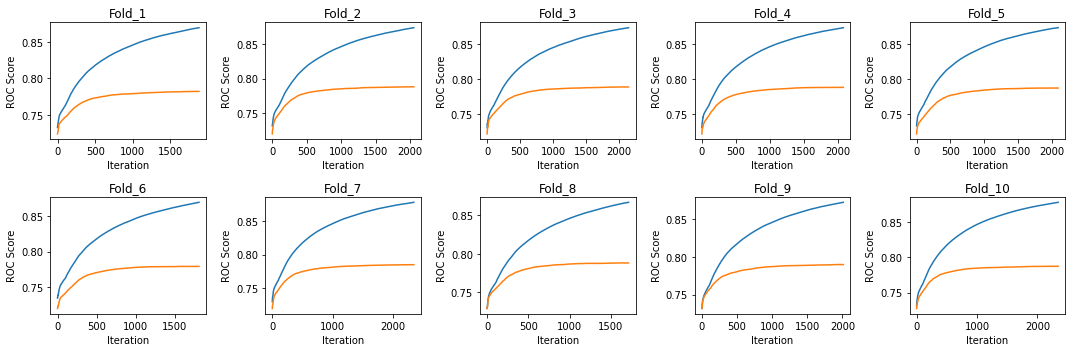

In [16]:
fig, axes = plt.subplots(2,5, figsize=(15,5))
axes = axes.flatten()

for idx,ax in enumerate(axes, start=1):
  tmp_train = evals_result_train[f'Fold_{idx}']['training']['auc']
  tmp_valid = evals_result_train[f'Fold_{idx}']['valid_1']['auc']
  ax.plot(range(len(tmp_train)), tmp_train)
  ax.plot(range(len(tmp_valid)), tmp_valid)
  ax.set_title(f'Fold_{idx}')
  ax.set_xlabel('Iteration') 
  ax.set_ylabel('ROC Score') 

plt.tight_layout()
plt.show()

In [17]:
threshs = np.linspace(0,1,100)

scores = {'TN':[],'FP':[],'FN':[],'TP':[],'F1_Score':[],'Precision':[], 'Recall':[]}

for th in threshs:
  y_Pred = app_train_wPreds['MEAN_PRED_raw'].apply(lambda x: 0 if x<th else 1)
  y_True = app_train_wPreds['TARGET']
  tn, fp, fn, tp = confusion_matrix(y_True, y_Pred).ravel()
  f1score = f1_score(y_True, y_Pred)
  precisionscore = precision_score(y_True, y_Pred)
  recallscore = recall_score(y_True, y_Pred)
  scores['TN'].append(tn), scores['FP'].append(fp), scores['FN'].append(fn), scores['TP'].append(tp)
  scores['F1_Score'].append(f1score), scores['Precision'].append(precisionscore), scores['Recall'].append(recallscore)

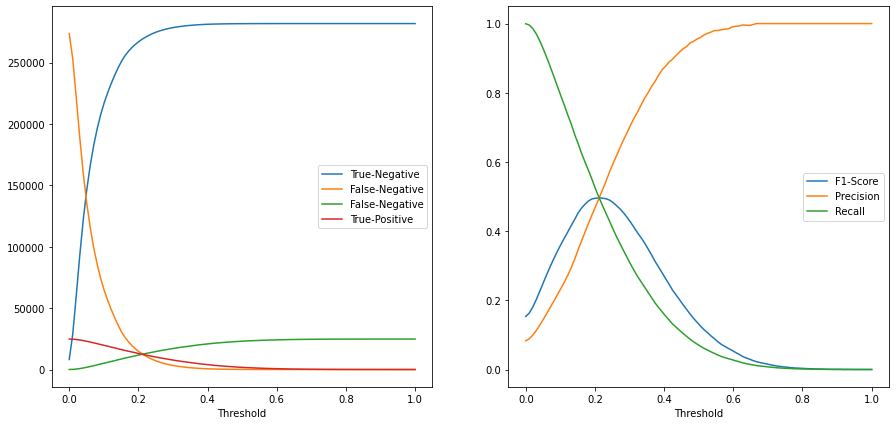

In [18]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes = axes.flatten()

axes[0].plot(threshs, scores['TN'], label='True-Negative') 
axes[0].plot(threshs, scores['FP'], label='False-Negative')
axes[0].plot(threshs, scores['FN'], label='False-Negative') 
axes[0].plot(threshs, scores['TP'], label='True-Positive')
axes[0].set_xlabel('Threshold')
axes[0].legend()

axes[1].plot(threshs, scores['F1_Score'], label='F1-Score') 
axes[1].plot(threshs, scores['Precision'], label='Precision')
axes[1].plot(threshs, scores['Recall'], label='Recall')
axes[1].set_xlabel('Threshold')
axes[1].legend()
plt.show()

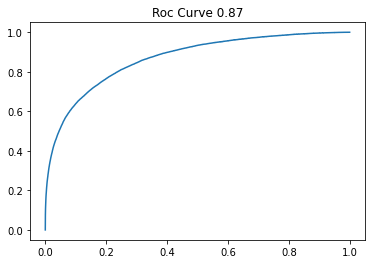

In [19]:
fpr, tpr, _ = roc_curve(app_train_wPreds['TARGET'], app_train_wPreds['MEAN_PRED_raw'])
roc_score = roc_auc_score(app_train_wPreds['TARGET'], app_train_wPreds['MEAN_PRED_raw'])

plt.plot(fpr, tpr)
plt.title(f'Roc Curve {round(roc_score, 2)}')
plt.show()

In [20]:
app_train_wPreds_submission = app_train[app_train['TARGET'].isnull()].copy()
X_submission = app_train_wPreds_submission.drop(['SK_ID_CURR','TARGET'], axis=1)
for key, model in models_dict.items():
  app_train_wPreds_submission[key] = model.predict(X_submission) 

In [21]:
app_train_wPreds_submission['TARGET'] = app_train_wPreds_submission[[e for e in app_train_wPreds_submission if 'Fold_' in e]].mean(axis=1)
app_train_wPreds_submission['TARGET'] = MinMaxScaler().fit_transform(app_train_wPreds_submission[['TARGET']])

In [22]:
submission = app_train_wPreds_submission[['SK_ID_CURR','TARGET']]

In [23]:
assert submission.shape[0] == pd.read_csv('sample_submission.csv').shape[0]

In [24]:
submission.to_csv('submission.csv', index=False)

In [25]:
! kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Message"

100% 1.25M/1.25M [00:00<00:00, 4.15MB/s]
Successfully submitted to Home Credit Default Risk